## Skeleton to implement 3D harmonic oscillator PES code in python.

# Step 0 a) Loading up needed modules.

In [3]:
%%time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import scipy
from scipy import special
from os import path
mpl.rcParams['font.size'] = 12

CPU times: user 46 µs, sys: 1e+03 ns, total: 47 µs
Wall time: 52 µs


# Step 0 b) Classes.

In [5]:
%%time
###########
# Classes #
###########

# Potentials.
class densities(object):
    def __init__(self,ngausshermx,ngausshermy,ngausshermz):
        self.rho = np.zeros([2,ngausshermx,ngausshermy,ngausshermz]) # First index is isospin.
        self.tau = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.kappa = np.zeros([2,ngausshermx,ngausshermy,ngausshermz]) + 1j*0.0 # Complex number
        self.divJ = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        
# Potentials.
class potentials(object):
    def __init__(self,ngausshermx,ngausshermy,ngausshermz):
        self.effmass = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.ure = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.wx = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.wy = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.wz = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.delta = np.zeros([2,ngausshermx,ngausshermy,ngausshermz]) + 0.0*1j  
        
# Coupling constants for energy density functional.
class ccedf(object):
    def __init__(self, iforce, isospin):
        if iforce == 7: # SeaLL1 (Phys Rev C 97, 044313). 
            # Homogenous interaction term.
            self.a0 = 0.0
            self.b0 = -684.524043779
            self.c0 = 827.26287841
            self.a1 = 64.2474102072
            self.b1 = 119.862146959
            self.c1 = -256.492703921
            self.a2 = -96.8354102072
            self.b2 = 449.22189682
            self.c2 = -461.650174489
            # Gradient term.
            self.etas = 81.3917529003
            self.claprho0 = -0.5*self.etas
            self.claprho1 = -0.5*self.etas
            self.claprhop = self.claprho0 + isospin*self.claprho1
            self.claprhon = self.claprho0 - isospin*self.claprho1
            # Spin orbit.
            self.w0 = 73.5210618422
            self.cdivJ0 = -self.w0
            self.cdivJ1 = 0.0
            self.cdivJp = self.cdivJ0 + isospin*self.cdivJ1
            self.cdivJn = self.cdivJ0 - isospin*self.cdivJ1
            # Pairing coupling constants.
            self.gg0p = -200.0
            self.gg0n = -200.0

CPU times: user 65 µs, sys: 1 µs, total: 66 µs
Wall time: 71 µs


# Step 0 c) Functions.

In [29]:
%%time
##############################
# Functions Related to Basis #
##############################

# Counts total number of allowed states given nshells. 
def obtainNumStates(nshells):
    nstates = 0
    for i in range(nshells):
        for ix in range(i+1): # ix can go from 0 to N, which is represented by i. 
            for iy in range(i+1): # ix can go from 0 to N, which is represented by i. 
                for iz in range(i+1): # ix can go from 0 to N, which is represented by i. 
                    if iz+iy+ix != i:
                        continue
                    nstates +=2 # For spin!    
    return nstates

# Records the energies and quantum numbers of the allowed states.
def obtainQuanNums(nstates,nshells,hbaromegax,hbaromegay,hbaromegaz):
    eho = np.zeros(nstates)
    qnums = np.zeros([5,nstates])
    ifill = 0
    for i in range(nshells):
        for ix in range(i+1): # ix can go from 0 to N, which is represented by i. 
            for iy in range(i+1): # ix can go from 0 to N, which is represented by i. 
                for iz in range(i+1): # ix can go from 0 to N, which is represented by i. 
                    if iz+iy+ix != i:
                        continue
                    for ispin in range(2):
                        eho[ifill] = hbaromegax*(ix+0.5)+hbaromegay*(iy+0.5)+hbaromegaz*(iz+0.5)
                        qnums[0,ifill] = i
                        qnums[1,ifill] = ix
                        qnums[2,ifill] = iy
                        qnums[3,ifill] = iz
                        qnums[4,ifill] = ispin 
                        ifill +=1 # For spin!          
    return eho, qnums

# Normalization of Hermite polynomial.
def normHermite(nx): 
    Nnx = np.sqrt(1/(np.sqrt(np.pi)*2.0**nx*math.factorial(int(nx))))
    return Nnx

# Normalization array of Hermite polynomial for a given number of shells.
def normHermite1D(nshells):
    normhermx = np.zeros(nshells)
    for i in range(nshells):
        normhermx[i]=normHermite(i)
    return normhermx

# Returns Gauss-Hermite quadrature points, weights, and spatial coordinates.  
def quadCoordinates(ngauss,betax):
    # Defining quadrature points and weights.
    xix, xiwx = np.polynomial.hermite.hermgauss(ngauss)
    xiwx = xiwx/np.exp(-xix**2.0) 
    # Corresponding values in coordinate space.
    x = xix/betax
    return xix, xiwx, x

# Constructing basis functions along 1 dimension. 
def basisHermite(ngauss,nshells,normherm,xix):
    # Initialization.
    basisherm = np.zeros([ngauss,nshells]) 
    # Filling in basis functions.
    for i in range(nshells):
        function = special.hermite(int(i), monic=True)  
        fact=2.0**i*np.exp(-xix**2.0/2.0) # Extra factor of 2.0^nx is required
        basisherm[:,i]= function(xix)*normherm[i]*fact 
    return basisherm

# Constructing basis derivatives along 1 dimension. 
def dbasisHermite(hbaromega,hbar2m,basisherm,ngauss,nshells,xix):
    # Pre factor.  
    factor = -0.5*np.sqrt(hbaromega/hbar2m)
    # Initialization.
    dbasisherm = np.zeros([ngauss,nshells]) 
    # Filling in basis functions.
    for i in range(nshells):
        if i == 0:
            dbasisherm[:,i]= np.sqrt(i+1.0)*basisherm[:,i+1]
        else:
            dbasisherm[:,i]= np.sqrt(i+1.0)*basisherm[:,i+1]-np.sqrt(i)*basisherm[:,i-1]
    dbasisherm = factor*dbasisherm
    return dbasisherm

# Constructs basis functions along 3 dimensions.  
def basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,basishermx,basishermy,basishermz):
    # Precompute indices
    nxvalues = qnums[1, :].astype(int)
    nyvalues = qnums[2, :].astype(int)
    nzvalues = qnums[3, :].astype(int)
    # Initialize arrays.
    basisproduct = np.zeros((nstates,ngausshermx,ngausshermy,ngausshermz))
    basisfull = np.zeros((nstates, 2, ngausshermx, ngausshermy, ngausshermz))
    # Basis states.
    for i in range(nstates):
        basisproduct[i] = (
            np.outer(basishermx[:, nxvalues[i]], 
                     np.outer(basishermy[:, nyvalues[i]], 
                              basishermz[:, nzvalues[i]]
                             ).reshape(-1)
                    ).reshape(ngausshermx, ngausshermy, ngausshermz)
        )
    # Assign values based on spin index.
    basisfull[0::2, 0] = basisproduct[0::2]
    basisfull[1::2, 1] = basisproduct[1::2]
    return basisfull 

##################################
# Functions Related to Densities #
##################################

# Defines erf function in 1-D for initializing densities.
def erf(x,lx): 
    erffunc = np.zeros(lx)
    for i in range(lx):
        erffunc[i] = 1.0-math.erf(x[i])
    return erffunc

# Computes 3d integral.
def integrate3D(ngausshermx,ngausshermy,ngausshermz,x,y,z,integrand):
    integrand1 = np.trapz(integrand, z, axis=2)
    integrand2 = np.trapz(integrand1, y, axis=1)
    sums = np.trapz(integrand2, x)
    return sums
    
# Initializes densities to a Gaussian esq function normalized to yield approximately the correct number of neutrons and protons.  
# Should be extended to non spherical starting densities.  
def initDens(A,N,npoints,ngausshermx,ngausshermy,ngausshermz,x,y,z):
    # Scan small range of radii while keeping everything else constant. # Much better optimizations exist. 
    r0 = 1.2*A**(1./3.)
    r0trial = np.linspace(0.6*r0,r0,npoints)
    # Keep track of sums. 
    sums = np.zeros(npoints)
    # Computes densities for various radii. 
    rho = np.zeros([ngausshermx,ngausshermy,ngausshermz])
    for i in range(npoints):
        # 1D densities.
        xstart=0.5*erf((np.abs(x)-r0trial[i])/1.8,ngausshermx)
        ystart=0.5*erf((np.abs(y)-r0trial[i])/1.8,ngausshermy)
        zstart=0.5*erf((np.abs(z)-r0trial[i])/1.8,ngausshermz)
        # 3D density.
        rho = 0.08 * np.outer(xstart, np.outer(ystart, zstart).reshape(-1)).reshape(ngausshermx, ngausshermy, ngausshermz) 
        sums[i] = integrate3D(ngausshermx,ngausshermy,ngausshermz,x,y,z,rho)
    ir0 = np.argmin(np.abs(sums-N))
    # Computes correct density.
    # 1D densities.
    xstart=0.5*erf((np.abs(x)-r0trial[ir0])/1.8,ngausshermx)
    ystart=0.5*erf((np.abs(y)-r0trial[ir0])/1.8,ngausshermy)
    zstart=0.5*erf((np.abs(z)-r0trial[ir0])/1.8,ngausshermz)
    # 3D density.
    rho = 0.08 * np.outer(xstart, np.outer(ystart, zstart).reshape(-1)).reshape(ngausshermx, ngausshermy, ngausshermz)
    return rho

###################################
# Functions Related to Potentials #
###################################

# Constructs potentials from densities.
def constPots(pots,dens,hbar2m,ccedfp,ccedfn,iharmonic,ngausshermx,ngausshermy,ngausshermz):
    # Defining the effective mass (simple for SeaLL1).
    pots.effmass[:,:,:,:] = hbar2m
    # Defining the central potential.
    esp = 10**(-14.0) # Prevents division by zero. 
    rho0 = dens.rho[0,:,:,:]+dens.rho[1,:,:,:]
    rho1 = dens.rho[0,:,:,:]-dens.rho[1,:,:,:]
    for iso in range(2):
        if iso == 0: # Protons interaction term.
            pots.ure[iso,:,:,:] = 5.0/3.0*ccedfp.a0*rho0**(2.0/3.0) + 2.0*ccedfp.b0*rho0 + 7.0/3.0*ccedfp.c0*rho0**(4.0/3.0) \
            - 1.0/3.0*ccedfp.a1*rho1**2.0/(rho0**(4.0/3.0)+esp) + 1.0/3.0*ccedfp.c1*rho1**2.0/(rho0**(2.0/3.0)+esp) \
            - 7.0/3.0*ccedfp.a2*rho1**4.0/(rho0**(10.0/3.0)+esp) + 2.0*ccedfp.b2*rho1**4.0/(rho0**(3.0)+esp) + 5.0/3.0*ccedfp.c2*rho1**4.0/(rho0**(8.0/3.0)+esp) \
            + 2.0*ccedfp.a1*rho1/(rho0**(1.0/3.0)+esp) + 2.0*ccedfp.b1*rho1 + 2.0*ccedfp.c1*rho1*rho0**(1.0/3.0) \
            + 4.0*ccedfp.a2*rho1**3.0/(rho0**(7.0/3.0)+esp) + 4.0*ccedfp.b2*rho1**3.0/(rho0**2.0+esp) + 4.0*ccedfp.c2*rho1**3.0/(rho0**(5.0/3.0)+esp) 
        else: # Neutrons interaction term.
            pots.ure[iso,:,:,:] = 5.0/3.0*ccedfn.a0*rho0**(2.0/3.0) + 2.0*ccedfn.b0*rho0 + 7.0/3.0*ccedfn.c0*rho0**(4.0/3.0) \
            - 1.0/3.0*ccedfn.a1*rho1**2.0/(rho0**(4.0/3.0)+esp) + 1.0/3.0*ccedfn.c1*rho1**2.0/(rho0**(2.0/3.0)+esp) \
            - 7.0/3.0*ccedfn.a2*rho1**4.0/(rho0**(10.0/3.0)+esp) + 2.0*ccedfn.b2*rho1**4.0/(rho0**(3.0)+esp) + 5.0/3.0*ccedfn.c2*rho1**4.0/(rho0**(8.0/3.0)+esp) \
            - 2.0*ccedfn.a1*rho1/(rho0**(1.0/3.0)+esp) - 2.0*ccedfn.b1*rho1 - 2.0*ccedfn.c1*rho1*rho0**(1.0/3.0) \
            - 4.0*ccedfn.a2*rho1**3.0/(rho0**(7.0/3.0)+esp) - 4.0*ccedfn.b2*rho1**3.0/(rho0**2.0+esp) - 4.0*ccedfn.c2*rho1**3.0/(rho0**(5.0/3.0)+esp) 
    # Harmonic oscillator potential (for testing purposes).
    if iharmonic == 1:
        oscx = 0.25*(1/hbar2m)*hbaromegax**2.0
        oscy = 0.25*(1/hbar2m)*hbaromegay**2.0
        oscz = 0.25*(1/hbar2m)*hbaromegaz**2.0
        for iso in range(2):
            for ix in range(ngausshermx):
                for iy in range(ngausshermy):
                    for iz in range(ngausshermz):
                        pots.ure[iso,ix,iy,iz] = oscx*x[ix]**2.0 + oscy*y[iy]**2.0 + oscz*z[iz]**2.0 

# Renormalizing coupling constant (more complicated once we switch away from SeaLL1 and have a non trivial effective mass).  
def renormPaircoupling(pots,mup,mun,ccedfp,ccedfn,ngausshermx,ngausshermy,ngausshermz):
    pc = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
    ureal = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
    for iso in range(2):
        if iso == 0:
            ureal[iso,:,:,:] = pots.ure[iso,:,:,:] - mup
        else:
            ureal[iso,:,:,:] = pots.ure[iso,:,:,:] - mun
        p0 = np.sqrt(np.abs(ureal)/pots.effmass)
        for ix in range(ngausshermx):
            for iy in range(ngausshermy):
                for iz in range(ngausshermz):
                    if ecut > ureal[iso,ix,iy,iz]:
                        pc[iso,ix,iy,iz] = np.sqrt((ecut - ureal[iso,ix,iy,iz])/pots.effmass[iso,ix,iy,iz])
                        if ureal[iso,ix,iy,iz] < 0.0:
                            pc[iso,ix,iy,iz] = pc[iso,ix,iy,iz] - 0.5*p0[iso,ix,iy,iz]*np.log((pc[iso,ix,iy,iz]+p0[iso,ix,iy,iz])/(pc[iso,ix,iy,iz]-p0[iso,ix,iy,iz]))
                        else:
                            pc[iso,ix,iy,iz] = pc[iso,ix,iy,iz] + p0[iso,ix,iy,iz]*np.arctan(p0[iso,ix,iy,iz]/pc[iso,ix,iy,iz])
                    else:
                        pc[iso,ix,iy,iz] = 0.0           
    geffp = ccedfp.gg0p*(1.0-ccedfp.gg0p*pc[0,:,:,:]/(4*np.pi**2.0*pots.effmass[0,:,:,:]))
    geffn = ccedfn.gg0n*(1.0-ccedfp.gg0p*pc[1,:,:,:]/(4*np.pi**2.0*pots.effmass[1,:,:,:]))
    return geffp, geffn

# Constructs pairing field from anomalous density.
def constDelta(pots,dens,geffp,geffn,iconstpair):
    # Initial pairing field.
    pots.delta[0,:,:,:] = -geffp*dens.kappa[0,:,:,:] + 0.0*1j
    pots.delta[1,:,:,:] = -geffn*dens.kappa[1,:,:,:] + 0.0*1j
    if iconstpair == 1:
        pots.delta[0,:,:,:] = -40.0
        pots.delta[1,:,:,:] = -40.0

##########################################
# Functions Related to Coulomb Potential #
##########################################

# Computes laplaciean of number density.  
def compLaplrho(rho,x,y,z):
    d2rho_dx2 = np.gradient(np.gradient(rho,x,axis=0),x, axis=0)
    d2rho_dy2 = np.gradient(np.gradient(rho,y,axis=1),y, axis=1)
    d2rho_dz2 = np.gradient(np.gradient(rho,z,axis=2),z, axis=2)
    laplrho = d2rho_dx2 + d2rho_dy2 + d2rho_dz2
    return laplrho

# Computes direct contribution of Coulomb potential. 
def compVcouldirect(e2,laplrho,ngausshermx,ngausshermy,ngausshermz,x,y,z):
    # Initializing arrays.  
    vcdir = np.zeros([ngausshermx,ngausshermy,ngausshermz])
    # Mesh grid to speed up calculation.
    Xp, Yp, Zp = np.meshgrid(x, y, z, indexing="ij")
    # Computing all points in vcdir.
    for ix in range(ngausshermx):
        for iy in range(ngausshermy):
            for iz in range(ngausshermz):
                # Computing integrand.  
                rmrp = np.sqrt((x[ix] - Xp)**2 + (y[iy] - Yp)**2 + (z[iz] - Zp)**2)
                integrand = rmrp * laplrho
                vcdir[ix,iy,iz] = 0.5*e2*integrate3D(ngausshermx,ngausshermy,ngausshermz,x,y,z,integrand)
    vcdir = 0.5*e2*vcdir
    return vcdir

# Computes exchange contribution of Coulomb potential.  
def compVcoulexchange(e2,rhop):
    vcex = -e2*(3.0*rhop/np.pi)**(1./3.)
    return vcex

##############################################
# Functions Related to Spin Orbit Potential. #
##############################################

# Computes gradient of number density.  
def compGradrho(rho,ngausshermx,ngausshermy,ngausshermz,x,y,z):
    drhox = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
    drhoy = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
    drhoz = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
    for iso in range(2):
        drhox[iso,:,:,:] = np.gradient(rho[iso,:,:,:],x,axis=0)
        drhoy[iso,:,:,:] = np.gradient(rho[iso,:,:,:],y,axis=1)
        drhoz[iso,:,:,:] = np.gradient(rho[iso,:,:,:],z,axis=2)
    return drhox, drhoy, drhoz

# Computes spin orbit potential.
def compWso(pots,ccedf,drhox,drhoy,drhoz,isospin):
    if isospin == 1: 
        iso = 0
    elif isospin == -1:
        iso = 1
    pots.wx[iso,:,:,:] = ccedf.cdivJp*drhox[0,:,:,:] + ccedf.cdivJn*drhox[1,:,:,:]  
    pots.wy[iso,:,:,:] = ccedf.cdivJp*drhoy[0,:,:,:] + ccedf.cdivJn*drhoy[1,:,:,:]
    pots.wz[iso,:,:,:] = ccedf.cdivJp*drhoz[0,:,:,:] + ccedf.cdivJn*drhoz[1,:,:,:]
    # Note: does not have 0.5 factor because we do not symmetrize, but should be double checked in future.   

#####################################
# Functions Related to Hamiltonian. #
#####################################
    
# Computes 3D integral using Gauss-Hermite quad.
def integrate3DGH(xiwx,xiwy,xiwz,integrand):
    integral1 = np.sum(integrand*xiwz,axis=-1)
    integral2 = np.sum(integral1*xiwy,axis=-1)
    sums = np.sum(integral2*xiwx)
    return sums

# Computes Hamiltonian. 
def compHam(ndim,iso,pots,mu,xiwx,xiwy,xiwz,basisfull,dxbasisfull,dybasisfull,dzbasisfull,qnums):
    # Initialize matrix.
    hamp = np.zeros([2 * ndim, 2 * ndim])+0.0*1j
    # Filling matrix. 
    for i in range(ndim):
        ispin = i % 2
        if i % 100 == 0:
            print(i)
        for j in range(ndim):
            jspin = j % 2
            if i >= j:
                # Central potential.
                if ispin==jspin:
                    integrand = pots.ure[iso, :, :, :] * basisfull[i, ispin, :, :, :] * basisfull[j, jspin, :, :, :]
                    integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                    hamp[i,j] = integral
                    # Chemical potential.
                    if i==j:
                        hamp[i,j] = hamp[i,j] - mu
                # Pairing contribution.     
                if ispin !=jspin: # Adding this makes it faster.
                    # Uv
                    if ispin == 0:
                        integrand = pots.delta[iso,:,:,:]* basisfull[i, ispin, :, :, :]*basisfull[j, 1, :, :, :]
                    else:
                        integrand = -pots.delta[iso,:,:,:]* basisfull[i, ispin, :, :, :]*basisfull[j, 0, :, :, :]
                    integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                    hamp[i,j+nstates] = hamp[i,j+nstates] +integral
                    # Vu
                    if ispin == 0:
                        integrand = -np.conj(pots.delta[iso,:,:,:])* basisfull[i, ispin, :, :, :]*basisfull[j, 1, :, :, :]
                    else:
                        integrand = np.conj(pots.delta[iso,:,:,:])* basisfull[i, ispin, :, :, :]*basisfull[j, 0, :, :, :]
                    integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                    hamp[i+nstates,j] = hamp[i+nstates,j] +integral
                # Kinetic part.
                if ispin==jspin:
                    if qnums[2,i]==qnums[2,j] and qnums[3,i]==qnums[3,j]: # x component. 
                        if qnums[1,i] == qnums[1,j]:      
                            hamp[i,j] = hamp[i,j] + 0.25*hbaromegax*(2*qnums[1,j]+1.0)
                        if qnums[1,i] == qnums[1,j]-2.0:      
                            hamp[i,j] = hamp[i,j] - 0.25*hbaromegax*np.sqrt(qnums[1,j])*np.sqrt(qnums[1,j]-1.0)
                        if qnums[1,i] == qnums[1,j]+2.0:      
                            hamp[i,j] = hamp[i,j] - 0.25*hbaromegax*np.sqrt(qnums[1,j]+1.0)*np.sqrt(qnums[1,j]+2.0)
                    if qnums[1,i]==qnums[1,j] and qnums[3,i]==qnums[3,j]: # y component. 
                        if qnums[2,i] == qnums[2,j]:      
                            hamp[i,j] = hamp[i,j] + 0.25*hbaromegay*(2*qnums[2,j]+1.0)
                        if qnums[2,i] == qnums[2,j]-2.0:      
                            hamp[i,j] = hamp[i,j] - 0.25*hbaromegay*np.sqrt(qnums[2,j])*np.sqrt(qnums[2,j]-1.0)
                        if qnums[2,i] == qnums[2,j]+2.0:      
                            hamp[i,j] = hamp[i,j] - 0.25*hbaromegay*np.sqrt(qnums[2,j]+1.0)*np.sqrt(qnums[2,j]+2.0)
                    if qnums[1,i]==qnums[1,j] and qnums[2,i]==qnums[2,j]: # z component. 
                        if qnums[3,i] == qnums[3,j]:      
                            hamp[i,j] = hamp[i,j] + 0.25*hbaromegaz*(2*qnums[3,j]+1.0)
                        if qnums[3,i] == qnums[3,j]-2.0:      
                            hamp[i,j] = hamp[i,j] - 0.25*hbaromegaz*np.sqrt(qnums[3,j])*np.sqrt(qnums[3,j]-1.0)
                        if qnums[3,i] == qnums[3,j]+2.0:      
                            hamp[i,j] = hamp[i,j] - 0.25*hbaromegaz*np.sqrt(qnums[3,j]+1.0)*np.sqrt(qnums[3,j]+2.0)
                # Spin orbit contribution (terms coupling with sigmaz).
                if ispin==jspin:
                    # Sigma z.
                    if ispin == 0:
                        integrand = -1j*basisfull[i, ispin, :, :, :] * (pots.wx[iso, :, :, :] * dybasisfull[j, jspin, :, :, :]-\
                                                            pots.wy[iso, :, :, :] * dxbasisfull[j, jspin, :, :, :])
                    else:
                        integrand = 1j*basisfull[i, ispin, :, :, :] * (pots.wx[iso, :, :, :] * dybasisfull[j, jspin, :, :, :]-\
                                                                pots.wy[iso, :, :, :] * dxbasisfull[j, jspin, :, :, :])
                    integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                    hamp[i,j] = hamp[i,j] + integral
                # Spin orbit contribution (terms coupling with sigmay and sigmax).
                if ispin !=jspin:
                    # Sigma x.
                    if ispin == 0:
                        integrand = -1j*basisfull[i, ispin, :, :, :] * (pots.wy[iso, :, :, :] * dzbasisfull[j, 1, :, :, :]-\
                                                            pots.wz[iso, :, :, :] * dybasisfull[j, 1, :, :, :])
                    else:
                        integrand = -1j*basisfull[i, ispin, :, :, :] * (pots.wy[iso, :, :, :] * dzbasisfull[j, 0, :, :, :]-\
                                                            pots.wz[iso, :, :, :] * dybasisfull[j, 0, :, :, :])
                    integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                    hamp[i,j] = hamp[i,j] + integral
                    # Sigma y. 
                    if ispin == 0:
                        integrand = -1.0*basisfull[i, ispin, :, :, :] * (pots.wz[iso, :, :, :] * dxbasisfull[j, 1, :, :, :]-\
                                                            pots.wx[iso, :, :, :] * dzbasisfull[j, 1, :, :, :])
                    else:
                        integrand = basisfull[i, ispin, :, :, :] * (pots.wz[iso, :, :, :] * dxbasisfull[j, 0, :, :, :]-\
                                                            pots.wx[iso, :, :, :] * dzbasisfull[j, 0, :, :, :])
                    integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                    hamp[i,j] = hamp[i,j] + integral                    
                # V component part.
                hamp[i+ndim,j+ndim] = -np.conj(hamp[i,j])  
    # Compute second part of triangle.   
    hamp = hamp + np.conj(np.transpose(hamp))- np.diag(np.diagonal(hamp)) 
    return hamp

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 18.8 µs


# Step 1) Defining the basis.

In [30]:
%%time
# Independent Parameters.
Z = 8 # Proton number.
N = 12 # Neutron number.
nshells = 12 # Number of shells to consider.
ngausshermx = 40 # Number of Gauss Hermite quadrature points in the x direction.
ngausshermy = 40 # Number of Gauss Hermite quadrature points in the y direction.
ngausshermz = 40 # Number of Gauss Hermite quadrature points in the z direction.
ecut = 100.0 # Cutoff energy.

# Debug parameters. 
iharmonic = 0 # Uses harmonic oscillator potential for testing purposes. (Should be set to 0 for typical run).  
iconstpair = 0 # Uses a constant pairing field. (Should be set to 0 for typical run). 
isotest = 0 # Uses a vec(W) = vec(r) potential. (Should be set to 0 for typical run).  

# Constants.
massp = 938.272013 
massn = 939.565346 
hbarc = 197.3269631 
hbar2m = pow( hbarc , 2.0 ) / ( massp + massn ) 
mass = (massp + massn)/2.0
alphainv = 137.035999679
e2 = hbarc/alphainv

# Dependent Parameters.
A = N + Z # Mass number.
hbaromegax = 41.0/A**(1.0/3.0) # Oscillator frequency in x direction. Estimate from Ring and Schuck [MeV]. 
hbaromegay = 41.0/A**(1.0/3.0) # Oscillator frequency in y direction. Estimate from Ring and Schuck [MeV]. 
hbaromegaz = 41.0/A**(1.0/3.0) # Oscillator frequency in z direction. Estimate from Ring and Schuck [MeV]. 
bx = np.sqrt(2*hbar2m*(1/hbaromegax)) # Oscillator length in x direction.
betax = 1/bx # Oscillator constant in x direction.
by = np.sqrt(2*hbar2m*(1/hbaromegay)) # Oscillator length in y direction.
betay = 1/by # Oscillator constant in z direction.
bz = np.sqrt(2*hbar2m*(1/hbaromegaz)) # Oscillator length in z direction.
betaz = 1/bz # Oscillator constant.
print("A =", A, "N =", N, "Z =", Z)
print("[MeV] hbaromegax =", hbaromegax, "[MeV] hbaromegay =", hbaromegay, "[MeV] hbaromegaz =", hbaromegaz)

A = 20 N = 12 Z = 8
[MeV] hbaromegax = 15.104529144425586 [MeV] hbaromegay = 15.104529144425586 [MeV] hbaromegaz = 15.104529144425586
CPU times: user 353 µs, sys: 93 µs, total: 446 µs
Wall time: 428 µs


In [31]:
%%time
# Constructs the basis.
nstates = obtainNumStates(nshells)
eho, qnums = obtainQuanNums(nstates,nshells,hbaromegax,hbaromegay,hbaromegaz)
print(nstates)

728
CPU times: user 2.34 ms, sys: 130 µs, total: 2.47 ms
Wall time: 2.4 ms


# Step 2) Defining the corresponding basis states along each dimension, quadrature points, weights, and spatial coordinates.

In [32]:
%%time
# Defining the normalizations for all basis functions.
normhermx = normHermite1D(nshells+3) # We do +3 to include up to 2nd derivatives. 
normhermy = normHermite1D(nshells+3) 
normhermz = normHermite1D(nshells+3) 

# Defining quadrature points and weights, and corresponding values in coordinate space.
xix, xiwx, x = quadCoordinates(ngausshermx,betax) 
xiy, xiwy, y = quadCoordinates(ngausshermy,betay) 
xiz, xiwz, z = quadCoordinates(ngausshermz,betaz) 

# Filling in basis functions. 
basishermx = basisHermite(ngausshermx,nshells+3,normhermx,xix)
basishermy = basisHermite(ngausshermy,nshells+3,normhermy,xiy)
basishermz = basisHermite(ngausshermz,nshells+3,normhermz,xiz)

# Filling in 1st derivative basis.
dbasishermx = dbasisHermite(hbaromegax,hbar2m,basishermx,ngausshermx,nshells,xix)
dbasishermy = dbasisHermite(hbaromegay,hbar2m,basishermy,ngausshermy,nshells,xiy)
dbasishermz = dbasisHermite(hbaromegaz,hbar2m,basishermz,ngausshermz,nshells,xiz)

CPU times: user 11.5 ms, sys: 3.64 ms, total: 15.1 ms
Wall time: 12.1 ms


CPU times: user 14.1 ms, sys: 1.19 ms, total: 15.3 ms
Wall time: 14.4 ms


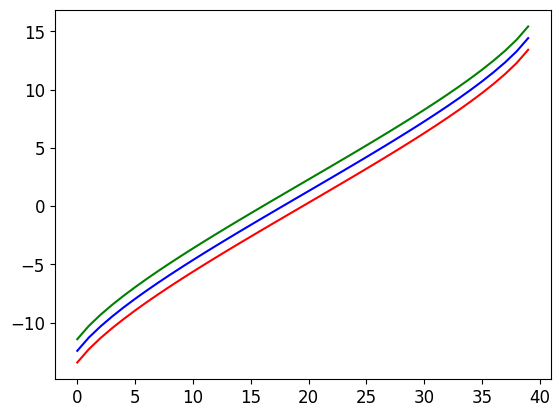

In [33]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Plotting coordinates (shifted slightly).
plt.plot(x,'r')
plt.plot(y+1,'b')
plt.plot(z+2,'g')

# Testing normalization of Hermite basis functions.
for i in range(nshells+3):
    test = np.sum(basishermx[:,i]*basishermx[:,i]*xiwx)
    if np.abs(test-1.0) > 1e-6:
        print(i,np.sum(basishermx[:,i]*basishermx[:,i]*xiwx))
    test = np.sum(basishermy[:,i]*basishermy[:,i]*xiwy)
    if np.abs(test-1.0) > 1e-6:
        print(i,np.sum(basishermy[:,i]*basishermy[:,i]*xiwy))
    test = np.sum(basishermz[:,i]*basishermz[:,i]*xiwz)
    if np.abs(test-1.0) > 1e-6:
        print(i,np.sum(basishermz[:,i]*basishermz[:,i]*xiwz))

# Step 3) Defining the 3D HO eigenfunctions.

In [34]:
%%time
# Computes basis in 3D.
basisfull = basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,basishermx,basishermy,basishermz)
dxbasisfull = basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,dbasishermx,basishermy,basishermz)
dybasisfull = basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,basishermx,dbasishermy,basishermz)
dzbasisfull = basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,basishermx,basishermy,dbasishermz)

CPU times: user 158 ms, sys: 177 ms, total: 335 ms
Wall time: 394 ms


In [35]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Testing normalization of the full basis functions
for i in range(nstates):
    integrand1 = np.sum(basisfull[i, :, :, :, :]**2 * xiwz, axis=-1)  # Summing over the last axis
    integrand2 = np.sum(integrand1 * xiwy, axis=-1)  # Summing over the `iy` axis
    integrand3 = np.sum(integrand2 * xiwz, axis=-1)  # Summing over the `ix` axis
    sums = np.sum(integrand3)  # Summing over spins
    if np.abs(sums - 1.0) > 1e-6:
        print(i, sums)

CPU times: user 92.7 ms, sys: 35.5 ms, total: 128 ms
Wall time: 138 ms


# Step 4) Defining the initial densities. 

In [36]:
# Initializing the densities. 
dens = densities(ngausshermx,ngausshermy,ngausshermz)

In [37]:
%%time
# Constructing starting densities (currently spherical).
dens.rho[0,:,:,:] = initDens(A,Z,1000,ngausshermx,ngausshermy,ngausshermz,x,y,z)
dens.rho[1,:,:,:] = initDens(A,N,1000,ngausshermx,ngausshermy,ngausshermz,x,y,z)
dens.kappa=0.08*dens.rho+0.0*1j # NEEDS SOMETHING
print("Z (start) N (start):")
print(integrate3D(ngausshermx,ngausshermy,ngausshermz,x,y,z,dens.rho[0,:,:,:]),\
                  integrate3D(ngausshermx,ngausshermy,ngausshermz,x,y,z,dens.rho[1,:,:,:]))

Z (start) N (start):
7.993532491884931 12.007059284258396
CPU times: user 310 ms, sys: 16.4 ms, total: 326 ms
Wall time: 324 ms


CPU times: user 26.7 ms, sys: 4.13 ms, total: 30.9 ms
Wall time: 27.5 ms


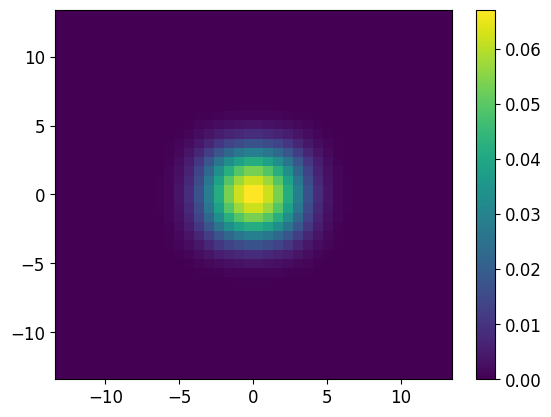

In [38]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Density profile.
plt.imshow(dens.rho[0,:,int(ngausshermy/2),:],extent=[x[0], x[-1], z[0], z[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar()

# Step 5) Constructing the initial potentials.

In [39]:
%%time
# Setting the coupling constants.
ccedfp = ccedf(7,1) # Protons.
ccedfn = ccedf(7,-1) # Neutrons.

CPU times: user 25 µs, sys: 1e+03 ns, total: 26 µs
Wall time: 31 µs


In [40]:
%%time
# Initializing the potentials. 
pots = potentials(ngausshermx,ngausshermy,ngausshermz)

# Initial chemical potentials.
mup = -12.5
mun = -12.5

# Constructs potentials. 
# Central potential.
constPots(pots,dens,hbar2m,ccedfp,ccedfn,iharmonic,ngausshermx,ngausshermy,ngausshermz)
# Pairing contribution.
geffp, geffn = renormPaircoupling(pots,mup,mun,ccedfp,ccedfn,ngausshermx,ngausshermy,ngausshermz)
constDelta(pots,dens,geffp,geffn,iconstpair)
# Coulomb potentials.
laplrho = compLaplrho(dens.rho[0,:,:,:],x,y,z)
vcdir = compVcouldirect(e2,laplrho,ngausshermx,ngausshermy,ngausshermz,x,y,z) # A bit slow.  
vcex = compVcoulexchange(e2,dens.rho[0,:,:,:])
pots.ure[0,:,:,:] = pots.ure[0,:,:,:] + vcex + vcdir
# Spin orbit potentials. 
drhox,drhoy,drhoz = compGradrho(dens.rho,ngausshermx,ngausshermy,ngausshermz,x,y,z)
compWso(pots,ccedfp,drhox,drhoy,drhoz,1)
compWso(pots,ccedfp,drhox,drhoy,drhoz,-1)
if isotest == 1:
    Xp, Yp, Zp = np.meshgrid(x, y, z, indexing="ij")
    acoeff = 5.0
    for iso in range(2):
        pots.wx[iso,:,:,:] = acoeff*Xp
        pots.wy[iso,:,:,:] = acoeff*Yp
        pots.wz[iso,:,:,:] = acoeff*Zp

CPU times: user 11.7 s, sys: 241 ms, total: 12 s
Wall time: 12 s


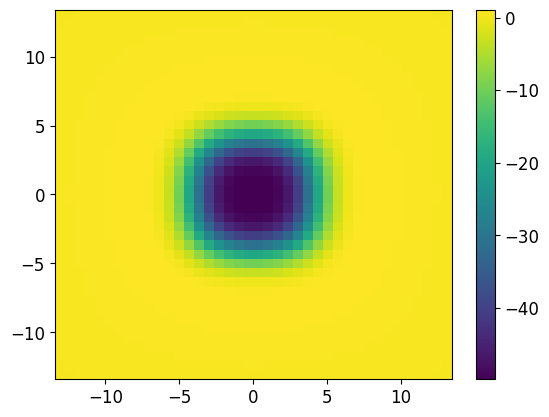

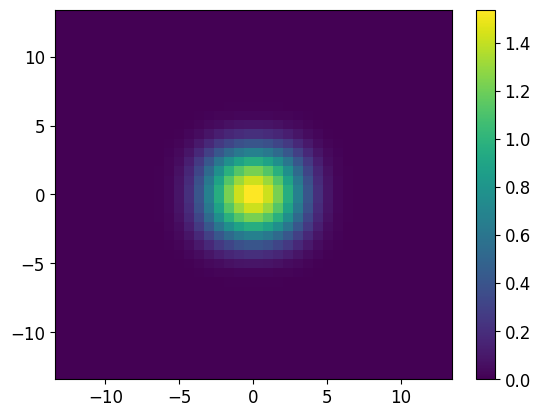

CPU times: user 229 ms, sys: 4.15 ms, total: 233 ms
Wall time: 86.6 ms


In [41]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Central potential.
plt.imshow(pots.ure[0,:,int(ngausshermy/2),:],extent=[x[0], x[-1], z[0], z[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()

# Magnitude of pairing field.
plt.imshow(np.abs(pots.delta[0,:,int(ngausshermy/2),:]),extent=[x[0], x[-1], z[0], z[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()

# Main Loop.
# Step 6) Constructing the Hamiltonian.

In [42]:
%%time
# Construct Hamiltonian.
hamp = compHam(nstates,0,pots,mup,xiwx,xiwy,xiwz,basisfull,dxbasisfull,dybasisfull,dzbasisfull,qnums)
hamn = compHam(nstates,1,pots,mun,xiwx,xiwy,xiwz,basisfull,dxbasisfull,dybasisfull,dzbasisfull,qnums)

0
100
200
300
400


KeyboardInterrupt: 

In [22]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Check if matrix is Hermitian. (Forced to be due to construction).  
print(np.sum(np.abs(hamp-np.conj(np.transpose(hamp)))))
print(np.sum(np.abs(hamn-np.conj(np.transpose(hamn)))))

6.642942673215751e-15
6.642942673215751e-15
CPU times: user 41.3 ms, sys: 16.9 ms, total: 58.3 ms
Wall time: 53.1 ms


# Step 7) Diagonalizing the Hamiltonian to obtain the eigenvectors and values.

In [23]:
%%time
# Diagonalize Hamiltonian. 
qpesp,eigvp = np.linalg.eigh(hamp)
qpesn,eigvn = np.linalg.eigh(hamn)
# Obtain single particle energies.
spesp, tmp = np.linalg.eigh(hamp[0:nstates,0:nstates])
spesn, tmp = np.linalg.eigh(hamn[0:nstates,0:nstates])

CPU times: user 12.2 s, sys: 1.24 s, total: 13.5 s
Wall time: 4.3 s


In [24]:
%%time
# Recording quasi-particle energies, single particle energies, and occupation numbers.
# Occupation numbers.
occsp = np.zeros(nstates)
occsn = np.zeros(nstates)
for i in range(nstates):
    occsp[i] = np.sum(np.abs(eigvp[nstates:2*nstates,i+nstates]**2.0))
    occsn[i] = np.sum(np.abs(eigvn[nstates:2*nstates,i+nstates]**2.0))
print("N = ", np.sum(occsn), "Z = ", np.sum(occsp))
print("mun = ", mun, "mup = ", mup)
# Saving qpes, spes, and occs.
np.savetxt('qpen.txt', np.c_[spesn,qpesn[nstates:2*nstates],occsn])
np.savetxt('qpep.txt', np.c_[spesp,qpesp[nstates:2*nstates],occsp])

N =  7.999709464887591 Z =  9.291451407020388
mun =  -12.5 mup =  -12.5
CPU times: user 22.3 ms, sys: 7.88 ms, total: 30.2 ms
Wall time: 1.1 s


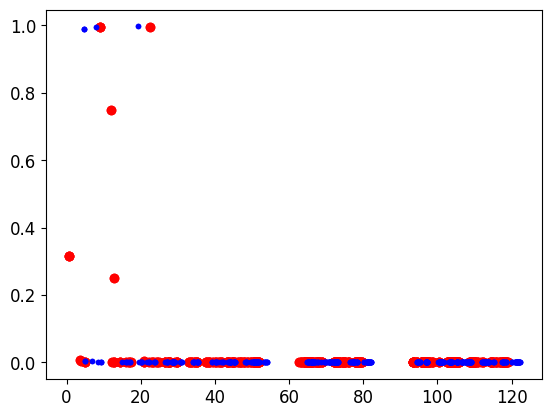

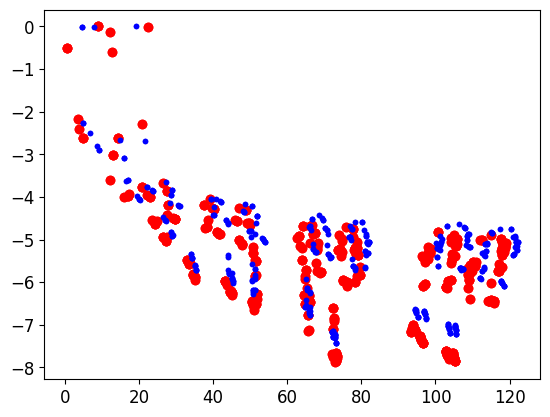

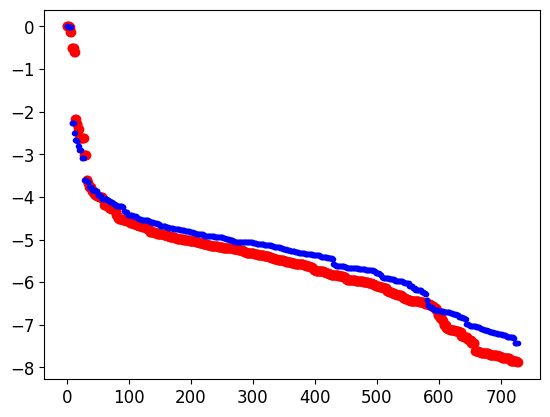

CPU times: user 168 ms, sys: 7.24 ms, total: 175 ms
Wall time: 173 ms


In [25]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Examining spectrum.  
plt.plot(qpesp[nstates:2*nstates],occsp,'or')
plt.plot(qpesn[nstates:2*nstates],occsn,'.b')
plt.show()
# Examining spectrum in log scale.  
plt.plot(qpesp[nstates:2*nstates],np.log10(occsp),'or')
plt.plot(qpesn[nstates:2*nstates],np.log10(occsn),'.b')
plt.show()
# Examining spectrum in log scale vs index and sorted.
plt.plot(np.flip(np.sort(np.log10(occsp))),'or')
plt.plot(np.flip(np.sort(np.log10(occsn))),'.b')
plt.show()

# Step 8) Obtaining the densities (with cutoff on number of quasi-particle wavefunctions).

In [26]:
#dens.rho

In [1]:
qpesp

NameError: name 'qpesp' is not defined

In [41]:
#rhokl = np.dot(np.conj(eigvp[nstates:,nstates:].T),eigvp[nstates:,nstates:])
rhokl = np.dot(eigvp[nstates:,nstates:],np.conj(eigvp[nstates:,nstates:].T))
tmp = np.zeros([ngausshermx, ngausshermy, ngausshermz]) + 0.0*1j
# Step 3: Loop over spins and vectorize the j loop
for ispin in range(2):
    for i in range(nstates):
        if i%100==1:
            print(i)
        # Vectorize the j loop
        contribution = np.sum(
            rhokl[i, :, None, None, None] * 
            basisfull[:, ispin, :, :, :] * 
            basisfull[i, ispin, :, :, :],
            axis=0  # Sum over the j dimension
        )
        tmp += contribution

1
101
201
301
401
501
601
701
1
101
201
301
401
501
601
701


In [46]:
test= integrate3DGH(xiwx,xiwy,xiwz,np.real(tmp))
print(test)

9.29145140702039


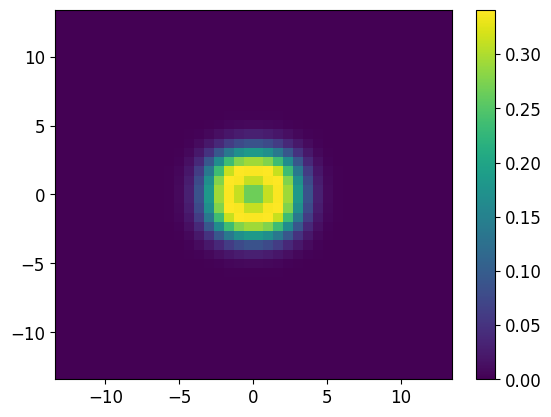

In [43]:
# Density profile.
plt.imshow(np.real(tmp[:,int(ngausshermy/2),:]),extent=[x[0], x[-1], z[0], z[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar()

In [105]:
rhokl = np.dot(np.conj(eigvp[nstates:,nstates:].T),eigvp[nstates:,nstates:])
tmp = np.zeros([ngausshermx, ngausshermy, ngausshermz]) + 0.0*1j
for ispin in range(2):
    for i in range(nstates):
        print(i)
        for j in range(nstates):
            tmp = tmp + rhokl[i,j]*basisfull[i, ispin, :, :, :]*basisfull[j, ispin, :, :, :] 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


KeyboardInterrupt: 

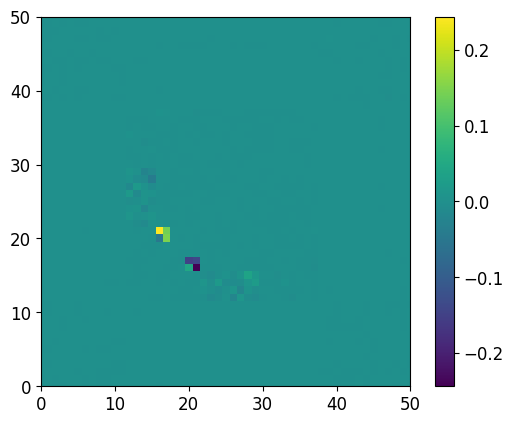

In [97]:
plt.imshow(np.imag(test))
plt.xlim(0,50)
plt.ylim(0,50)
plt.colorbar()

In [33]:
test = np.conj(eigvp[nstates:k+nstates,i+nstates])*\
            eigvp[nstates:k+nstates,i+nstates]

In [44]:
np.conj(eigvp[nstates:k+nstates+1,i+nstates])

array([3.52896344e-17-9.31154276e-19j, 5.72900113e-19+2.66562278e-19j])

In [50]:
tmp = np.zeros([2, ngausshermx, ngausshermy, ngausshermz]) + 0.0*1j
for ispin in range(2):
    conj_eigvp = np.conj(eigvp[nstates:, nstates:])  # Shape: (nstates, nstates)
    eigvp_square = conj_eigvp * eigvp[nstates:, nstates:]  # Shape: (nstates, nstates)
    basis_product = basisfull[:, ispin, :, :, :] * basisfull[:, ispin, :, :, :]  # Shape: (nstates, ngausshermx, ngausshermy, ngausshermz)
    tmp[ispin] = np.tensordot(eigvp_square.sum(axis=0), basis_product, axes=(0, 0))  # Contract over `nstates`

In [70]:
tmp = np.zeros([2, ngausshermx, ngausshermy, ngausshermz]) + 0.0*1j
for i in range(nstates):
    for ispin in range(2):
        tmp[0,:,:,:] = tmp[0,:,:,:] +occsp[i]*basisfull[i, ispin, :, :, :]*basisfull[i, ispin, :, :, :]

TypeError: Image data of dtype complex128 cannot be converted to float

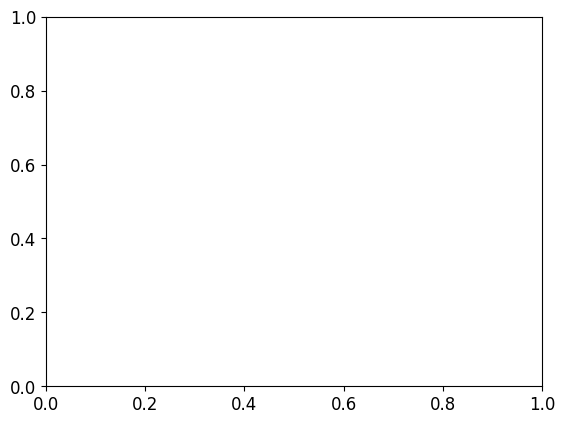

In [76]:
# Density profile.
plt.imshow(tmp[0,:,int(ngausshermy/2),:]+tmp[1,:,int(ngausshermy/2),:],extent=[x[0], x[-1], z[0], z[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar()

#tmp[0,:,:,:]

In [80]:
tmp = np.zeros([2, ngausshermx, ngausshermy, ngausshermz]) 
tmp2 = np.zeros([2, ngausshermx, ngausshermy, ngausshermz])
for i in range(nstates):
    for ispin in range(2):
        tmp[0,:,:,:] = tmp[0,:,:,:] +occsp[i]*basisfull[i, ispin, :, :, :]*basisfull[i, ispin, :, :, :]
        tmp2[0,:,:,:] = tmp2[0,:,:,:] +occsn[i]*basisfull[i, ispin, :, :, :]*basisfull[i, ispin, :, :, :]
test= integrate3DGH(xiwx,xiwy,xiwz,np.real(tmp))
test2= integrate3DGH(xiwx,xiwy,xiwz,np.real(tmp2))
print(test,test2)

9.291451407020391 7.999709464887594


In [ ]:
# Step 9) Extracting observables and checking convergence (if success skip to Step 12 - our of loop).

In [ ]:
# Step 10) Creating new potentials.

In [ ]:
# Step 11) Updating chemical potential and mixing potentials. 

In [ ]:
# Return back to Step 6.

In [51]:
# Step 12) Writing restart densities, potentials, or wavefunctions if desired.  